In [1]:
import numpy as np # linear algebra
import pandas as pd 
import io
import requests
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from scipy.stats import binned_statistic_2d

## Question 1
The [NYC Taxi and Limousine trip record data](https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv) was downloaded and read as data frame.

In [2]:
CSV_URL = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
s = requests.get(CSV_URL).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')))

There are 1,494,926 rows and 21 columns in the data set

In [3]:
nrow, ncol = data.shape
print('row number is', nrow)
print('column number is', ncol)

row number is 1494926
column number is 21


## Question 2
A description of Trip Distance was shown below before generating the histogram

In [4]:
data['Trip_distance'].describe()

count    1.494926e+06
mean     2.968141e+00
std      3.076621e+00
min      0.000000e+00
25%      1.100000e+00
50%      1.980000e+00
75%      3.740000e+00
max      6.031000e+02
Name: Trip_distance, dtype: float64

In [5]:
trip_less10 = data['Trip_distance'][data['Trip_distance']<10]
print('Around', "%.2f" % round(len(trip_less10)/nrow * 100,2), '% of trips under 10 miles')

Around 96.37 % of trips under 10 miles


Around 96.37 % trips are under 10 miles, a histogram of trips under 10 miles was generated

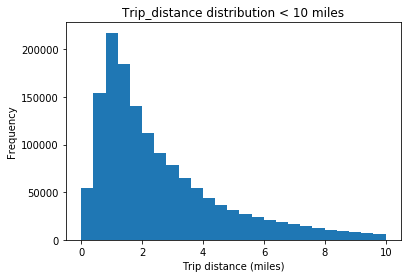

In [6]:
plt.hist(trip_less10, bins=25);
plt.title('Trip_distance distribution < 10 miles');
plt.xlabel('Trip distance (miles)');
plt.ylabel('Frequency');

The shape of the histogram looks like Lognormal distribution, then the trip distance data was used to fit a Lognormal distribution.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


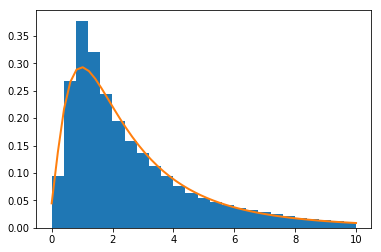

In [7]:
myHist = plt.hist(trip_less10, bins=25, normed=True)
s, l, m = lognorm.fit(data['Trip_distance'], data['Trip_distance'].mean() ,loc=0)
rv = lognorm(s, l, m)
x = np.linspace(0,10) 
h = plt.plot(x, rv.pdf(x), lw=2)

## Question 3
### 3.1 Mean and Median trip distance grouped by hour of day

In [8]:
data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'])
data['pickup_hour'] = data['lpep_pickup_datetime'].dt.hour
data_by_hour = data.groupby('pickup_hour').agg({'Trip_distance': ['mean', 'median']})

The mean and median trip distance grouped by hour of day are below

In [9]:
print(data_by_hour)

            Trip_distance       
                     mean median
pickup_hour                     
0                3.115276   2.20
1                3.017347   2.12
2                3.046176   2.14
3                3.212945   2.20
4                3.526555   2.36
5                4.133474   2.90
6                4.055149   2.84
7                3.284394   2.17
8                3.048450   1.98
9                2.999105   1.96
10               2.944482   1.92
11               2.912015   1.88
12               2.903065   1.89
13               2.878294   1.84
14               2.864304   1.83
15               2.857040   1.81
16               2.779852   1.80
17               2.679114   1.78
18               2.653222   1.80
19               2.715597   1.85
20               2.777052   1.90
21               2.999189   2.03
22               3.185394   2.20
23               3.191538   2.22


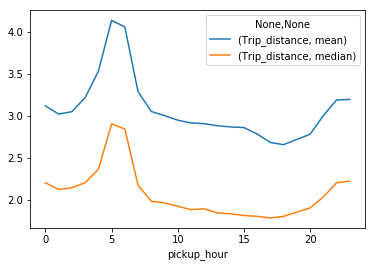

In [10]:
data_by_hour.plot()

### 3.2 Airport trips
According to [New York Taxi Fare information](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page), airport trips have **RateCodeID** = 2 or 3. Total 5552 airport trips, average **Total_amount** is $57.21.  

In [11]:
airport_trips = data.loc[data['RateCodeID'].isin([2,3]),]
airport_trips.agg({'Fare_amount': ['mean', 'count'], 
                   'Total_amount': ['mean', 'count']}).round(0)

,Fare_amount,Total_amount
mean,49.0,57.0
count,5552.0,5552.0


## Question 4
The goal of this problem is to build a predictive model for tip as a percentage of the total fare. The response variable is the tip as a percentage of the total fare (**Total_amount** - **Tip_amount**)

### 4.1 Clean data set

According to [Green Taxi Data Dictionary](http://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf), the **Tip_amount** is automatically populated for credit card tips and cash tips are not included; the **Total_amount** is charged to passengers and does not include cash tips as well. Thus, trips paid with credit cards were only considered in predictive modeling. 

In [12]:
Trips_credit = data.loc[(data['Payment_type']==1),:]

Trips have nagtive dollar may be due to data errors. They were changed back to positive amount

In [13]:
charge = ['Total_amount', 'Tip_amount', 'Tolls_amount', 
          'Fare_amount', 'Extra', 'MTA_tax', 'improvement_surcharge']

Trips_credit[charge] = Trips_credit[charge].abs()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


 147 Trips with **RateCodeID** = 5 indicated Negotiated fare, which were excluded because **Total_amount** was equal to **Tip_amount**. 3 trips paid by credit cards with **RateCodeID** = 99, which were invalid trips because **Dropoff_longitude**, 	**Dropoff_latitude** were all 0.00. According to [New York City Taxi Fare](http://www1.nyc.gov/site/tlc/passengers/taxi-fare.page), min fare of green taxi is 2.50 dollars for a trip. Thus, trips with **Total_amount** less than $ 2.50 were excluded 

In [14]:
Trips_credit_valid = Trips_credit.loc[(Trips_credit['Total_amount'] >= 2.50) & (Trips_credit['RateCodeID'] < 5)]

A new variable **Tips_precent** was derived for tip as a percentage of the total fare, which is the response variable in predictive modeling. 
              **Tips_percent** = (**Total_amount** - **Tip_amount**) / **Total_amount** * 100

In [15]:
Trips_credit_valid['Tip_percent'] = Trips_credit_valid['Tip_amount'] / (Trips_credit_valid['Total_amount'] - Trips_credit_valid['Tip_amount'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 4.2 Feature Egineering 

Extract the week number of the year, day of week and created indicator of weekday/weekend from pickup time stamps. 

In [16]:
def time_features(df, col):
    df['weekofyear'] = df[col].dt.weekofyear
    df['dayofweek'] = df[col].dt.dayofweek
    df['weekend'] = (df[col].dt.weekday >=5).astype(int)
    # df['hour'] = df[col].dt.hour

time_features(Trips_credit_valid, 'lpep_pickup_datetime')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

The **trip_time** (minutes) was created by differences between pickup time stamp and dropoff time stamp. And the **avg_speed** was created by **Trip_distance** divided by **trip_time**, infinity values and NaN was replaced by median of rest average speed.

In [17]:
Trips_credit_valid['Lpep_dropoff_datetime'] = pd.to_datetime(Trips_credit_valid['Lpep_dropoff_datetime'])
Trips_credit_valid['trip_time'] = (Trips_credit_valid['Lpep_dropoff_datetime'] - Trips_credit_valid['lpep_pickup_datetime']).dt.seconds/60.0
Trips_credit_valid['avg_speed'] = Trips_credit_valid['Trip_distance'] / Trips_credit_valid['trip_time']

med_speed = Trips_credit_valid['avg_speed'].quantile(0.5)
Trips_credit_valid['avg_speed'] = Trips_credit_valid['avg_speed'].fillna(med_speed)
Trips_credit_valid['avg_speed'] = Trips_credit_valid['avg_speed'].replace(np.inf, med_speed)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

A new indicator variable **Tolls** was created, 1 means tolls was included in this trip, otherwise 0. 

In [18]:
Trips_credit_valid['Tolls'] = Trips_credit_valid['Tolls_amount'].apply(lambda x: 0 if x == 0 else 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Longitudes and latitudes of pickup locations and dropoff locations were transferred to the Euclidean distance to median of coordinates of pickup and drop off location. Two new variables **pick_loc** and **drop_loc** were created

In [19]:
drop_log_med = np.median(Trips_credit_valid['Dropoff_longitude'])
drop_lat_med = np.median(Trips_credit_valid['Dropoff_latitude'])
Trips_credit_valid['pick_loc'] = (Trips_credit_valid['Dropoff_longitude'] - drop_log_med) ** 2 + (Trips_credit_valid['Dropoff_latitude'] - drop_lat_med) ** 2
pick_log_med = np.median(Trips_credit_valid['Pickup_longitude'])
pick_lat_med = np.median(Trips_credit_valid['Pickup_latitude'])
Trips_credit_valid['drop_loc'] = (Trips_credit_valid['Pickup_longitude'] - pick_log_med) ** 2 + (Trips_credit_valid['Pickup_latitude'] - pick_lat_med) ** 2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


According to [Green Taxi Data Dictionary](http://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf), **Passenger_count** was entered by driver, 0 value passenger count may be due to missing values so impute 1 which was the most frequent **Passenger_count**

In [20]:
Trips_credit_valid['Passenger_count'] = Trips_credit_valid['Passenger_count'].apply(lambda x: 1 if x == 0 else x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Target variable **Tip_percent** was extarcted saved separately. **Store_and_fwd_flag** was dropped due to it was unknown to pensengers, **Tip_amount, Tip_percent, lpep_pickup_datetime,  Lpep_dropoff_datetime, Pickup_longitude, Pickup_latitude, Dropoff_longitude, Dropoff_latitude** were drooped due to new variables related to them were created,  **Ehail_fee**  was dropped because it was all NAs

In [21]:
y = Trips_credit_valid['Tip_percent']
col_to_drop = ['Store_and_fwd_flag', 'Tip_amount', 'Tip_percent', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 'Ehail_fee']
for col in col_to_drop:
    Trips_credit_valid.drop([col], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**VendorID, RateCodeID, Extra, MTA_tax** were converted to category variables. **Extra** were 0 oronly includes the $0.50 and $1 rush hour and overnight charges. **MTA_tax** was 0 or only $0.50 MTA tax that is automatically triggered based on the metered rate in use.

In [22]:
def convert_to_categorical(data):
    for col in data.columns:
        if col in ['VendorID', 'RateCodeID', 'Extra', 'MTA_tax']:
            data[col] = data[col].astype('category')
    return data
Trip_credit = convert_to_categorical(Trips_credit_valid)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Due to limited resource of computer, linear models and tree-based models were applied to predict tip percent. Eligible data was split into training data (80%) and test data(20%). The 4 folds Cross Validation and random search were applied to training data to find best tuning parameters for each of three candidate models: Linear Regression with L1 norm (Lasso), Random Forest and Light Gradient Boosting Machine. **Light Gradient Boosting Machine** was selected because it has the least mean squared error on test data, comparing to Lasso or Random Forest. Three Python scripts and their log files were attached.


### Question 5

Anomaly Detection (Option D) was selected. Negative dollar amount numbers in data set were converted to positive values. These data errors can be fixed but did not mean abnormal trips. 

In [23]:
charge = ['Total_amount', 'Tip_amount', 'Tolls_amount', 'Fare_amount', 'Extra', 'MTA_tax', 'improvement_surcharge']
data[charge] = data[charge].abs()

The traveling time of each trip **trip_time** was created by difference between drop off time stamp and pick up time stamp. 

In [24]:
data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'])
data['Lpep_dropoff_datetime'] = pd.to_datetime(data['Lpep_dropoff_datetime'])
data['trip_time'] = (data['Lpep_dropoff_datetime'] - data['lpep_pickup_datetime']).dt.seconds/60.0/60.0

Trips has 0 miles **Trip_distance**, 0 seconds **trip_time** were considered as abnormal trips. According to [Taxi Fare](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page), intial charge is 2.50 dollars, trips with **Fare_amount** less than 2.50 dollars were abnormal trips. In addition to $2.50, the meter will charge 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped. Thus, **fare_per_mile** = (**Fare_amount**- 2.5) / **Trip_distance** should be at least 2.5, thus, trips had **fare_per_mile** less than 2.5 were abnormal trips. These abnormal trips mentioned before may be due to immediate cancellation of trips.

In [25]:
data['fare_per_mile'] = (data['Fare_amount'] - 2.5) / data['Trip_distance']

The average speed **avg_speed** was calculated by **Trip_distance** and **trip_time**.

In [26]:
data['avg_speed'] = data['Trip_distance'] / (data['trip_time']) 

After removing abnormal trips which may be due to immediate cancellation of trips. The average speed was used to detect abnormal trips

In [27]:
outliers_1 = data[(data['fare_per_mile'].isin([np.nan, np.inf, -np.inf])) | (data['avg_speed'].isin([np.nan, np.inf, -np.inf])) | (data['fare_per_mile'] > 0) | (data['avg_speed'] > 0) | (data['trip_time'] <= 0)]
data_no_errors = data[(~data['fare_per_mile'].isin([np.nan, np.inf, -np.inf])) & (~data['avg_speed'].isin([np.nan, np.inf, -np.inf])) & (data['fare_per_mile'] > 2.5) & (data['avg_speed'] > 0) & (data['trip_time'] > 0)]

For trips with Standard Fare in New York City (**RateCodeID** = 1), the average speed was usually under 40 MPH because these trips were in the city or close to the city. For trips outside the New York City (**RateCodeID** = 2, 3, 4) or negotiated fare trips (**RateCodeID** = 5), the average speed was usually under 80 MPH. Trips with average speed larger than 40MPH with **RateCodeID** = 1 or larger than 80MPH **RateCodeID** = 2,3,4,5 were abnormal trips. Large average speed trips were because of very large **Trip_distance** or extreme small **trip_time**.

In [28]:
Outliers_2 = data_no_errors.loc[(data_no_errors['RateCodeID'].isin([1])) & (data_no_errors['avg_speed'] > 40) | (data_no_errors['RateCodeID'].isin([2,3,4,5])) & (data_no_errors['avg_speed'] > 80),:] 
Outliers_2.describe().round(2)

,VendorID,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,pickup_hour,trip_time,fare_per_mile,avg_speed
count,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,0.0,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00,2662.00
mean,1.68,2.33,-72.30,39.87,-73.78,40.69,1.29,9.73,35.21,0.23,0.33,3.49,0.54,NaN,0.21,40.00,1.40,1.31,9.38,0.20,30.41,471.77
std,0.47,1.84,10.79,5.95,2.48,1.37,0.85,9.24,28.15,0.27,0.24,6.28,1.99,NaN,0.14,31.28,0.63,0.46,7.18,0.21,118.57,1676.09
min,1.00,1.00,-75.37,0.00,-75.26,0.00,0.00,0.03,3.50,0.00,0.00,0.00,0.00,NaN,0.00,3.50,1.00,1.00,0.00,0.00,2.50,40.00
25%,1.00,1.00,-73.95,40.70,-73.94,40.65,1.00,2.00,20.00,0.00,0.00,0.00,0.00,NaN,0.00,20.80,1.00,1.00,4.00,0.00,2.53,41.58
50%,2.00,1.00,-73.92,40.75,-73.87,40.72,1.00,8.93,30.50,0.00,0.50,0.00,0.00,NaN,0.30,35.16,1.00,1.00,7.00,0.19,2.57,45.49
75%,2.00,5.00,-73.87,40.81,-73.79,40.81,1.00,14.60,44.38,0.50,0.50,5.99,0.00,NaN,0.30,51.30,2.00,2.00,15.00,0.34,7.33,199.24
max,2.00,5.00,0.00,41.15,0.00,41.92,7.00,134.70,475.00,1.00,0.50,102.95,28.00,NaN,0.30,475.00,5.00,2.00,23.00,2.28,3184.67,35370.00


In [29]:
data_sub = data_no_errors[['Trip_distance', 'RateCodeID', 'trip_time', 'avg_speed']]

After removing abnormal average speed trips, 2D scattrplots in terms of **Trip_distance** and **trip_time** were provided. 

1. Trips with **RateCodeID** = 1

       Trip_distance  RateCodeID   trip_time   avg_speed
count     1392417.00   1392417.0  1392417.00  1392417.00
mean            3.00         1.0        0.34       12.72
std             2.83         0.0        1.61        5.37
min             0.01         1.0        0.00        0.00
25%             1.16         1.0        0.11        9.35
50%             2.05         1.0        0.18       11.69
75%             3.80         1.0        0.29       14.78
max           120.13         1.0       24.00       40.00


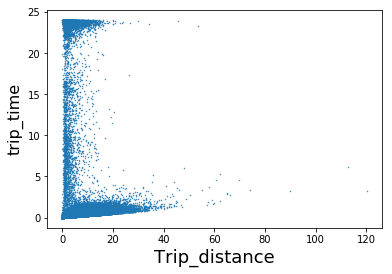

In [30]:
data_sub_loc = data_sub.loc[(data_sub['RateCodeID'].isin([1])) & (data_sub['avg_speed'] <= 40),:]
print(data_sub_loc.describe().round(2))
fig, ax = plt.subplots()
ax.scatter(data_sub_loc['Trip_distance'], data_sub_loc['trip_time'], s=.2)
# plt.xlim([0,70])
# plt.ylim([0,1000])
plt.xlabel('Trip_distance', fontsize=18)
plt.ylabel('trip_time', fontsize=16)
plt.show()

2. Trips with **RateCodeID** = 2,3,4,5

       Trip_distance  RateCodeID  trip_time  avg_speed
count       21735.00    21735.00   21735.00   21735.00
mean            5.72        4.47       0.50      17.13
std             7.04        1.08       2.04      11.53
min             0.01        2.00       0.00       0.00
25%             1.08        5.00       0.11       9.58
50%             2.65        5.00       0.22      13.54
75%             7.90        5.00       0.43      22.43
max            94.38        5.00      23.99      80.00


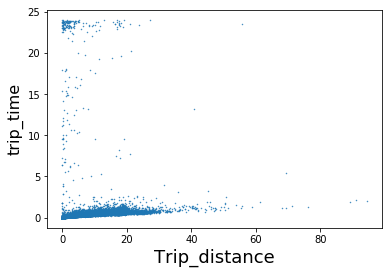

In [31]:
data_sub_sub = data_sub.loc[(data_sub['RateCodeID'].isin([2,3,4,5])) & (data_sub['avg_speed'] <= 80),:]
print(data_sub_sub.describe().round(2))
fig, ax = plt.subplots()
ax.scatter(data_sub_sub['Trip_distance'], data_sub_sub['trip_time'], s=.2)
# plt.xlim([0,70])
# plt.ylim([0,1000])
plt.xlabel('Trip_distance', fontsize=18)
plt.ylabel('trip_time', fontsize=16)
plt.show()

Two dimensions outliers detection methodology was attemped. A bidimensional binning was implemented and count of each bin were calculated. Following criteria were estabulised to detect abnormal trips. 

1. Points in bins with small count number were considered as outliers 
2. Points far away from large density population were considered as outliers 

Data was normalized before applying any methods to it

In [32]:
norm_data_sub_sub = preprocessing.normalize(data_sub_sub[['Trip_distance','trip_time']])
norm_data_sub_loc = preprocessing.normalize(data_sub_loc[['Trip_distance','trip_time']])

1. Trips with **RateCodeID** = 1

    The scatter plot below shows that red points were outliers. If trips count in a bin is less than 50 (Criterion 1), the trips inside this bin and trips with **trip_time** over 20 hours (Criterion 2) were considered as abnormal trips. These abnormal trips with large **trip_time** may be due to GPS function did not work well.

In [33]:
cut = 50
ret = binned_statistic_2d(data_sub_loc['Trip_distance'], data_sub_loc['trip_time'], None, 'count', bins=[120, 25], expand_binnumbers=True)

/opt/conda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [34]:
data_sub_loc['labels'] = [1] * len(data_sub_loc['Trip_distance'])

temp = np.argwhere(ret.statistic > cut)
for i in range(len(temp)):  
    data_sub_loc['labels'][(ret.binnumber[0]==temp[i][0]+1) & (ret.binnumber[1]==temp[i][1]+1)] = 0

data_sub_loc.loc[data_sub_loc['trip_time'] > 20,['labels']] = 1# Points far away from large density population were considered as outliers 
print(sum(data_sub_loc['labels']))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshe

8930


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


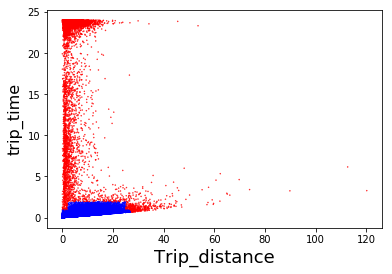

In [35]:
fig, ax = plt.subplots()
colors = {1:'red', 0:'blue'}

ax.scatter(data_sub_loc['Trip_distance'], data_sub_loc['trip_time'], c=data_sub_loc['labels'].apply(lambda x: colors[x]), s=.2)
plt.xlabel('Trip_distance', fontsize=18)
plt.ylabel('trip_time', fontsize=16)
plt.show()

2. Trips with **RateCodeID** = 2,3,4,5

    The scatter plot below shows that red points were outliers. If trips count in a bin is less than 10 (Criterion 1), the trips inside this bin and trips with **trip_time** over 20 hours (Criterion 2) were considered as abnormal trips. These abnormal trips with large **trip_time** may be due to GPS function did not work well.

In [36]:
cut = 10
ret = binned_statistic_2d(data_sub_sub['Trip_distance'], data_sub_sub['trip_time'], None, 'count', bins=[90, 25], expand_binnumbers=True)
print(ret.statistic[ret.statistic > cut].sum())
print(ret.statistic.sum() - ret.statistic[ret.statistic > cut].sum())

21377.0
358.0


/opt/conda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [37]:
# print(ret.binnumber)
data_sub_sub['labels'] = [1] * len(data_sub_sub['Trip_distance'])

temp = np.argwhere(ret.statistic > cut)
for i in range(len(temp)):  
    data_sub_sub['labels'][(ret.binnumber[0]==temp[i][0]+1) & (ret.binnumber[1]==temp[i][1]+1)] = 0
    
data_sub_sub.loc[data_sub_sub['trip_time'] > 20,['labels']] = 1# Points far away from large density population were considered as outliers 
sum(data_sub_sub['labels'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshe

454

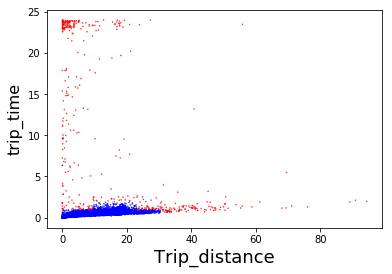

In [38]:
fig, ax = plt.subplots()
colors = {1:'red', 0:'blue'}

ax.scatter(data_sub_sub['Trip_distance'], data_sub_sub['trip_time'], c=data_sub_sub['labels'].apply(lambda x: colors[x]), s=.2)
plt.xlabel('Trip_distance', fontsize=18)
plt.ylabel('trip_time', fontsize=16)
plt.show()